In [53]:

# imports
import enum
import io
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchtext import datasets, vocab
from torchtext.data import Field
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np 


In [37]:
# batch functions
def batchify(data, bsz, device):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data#.to(device)

def batchify_pad(data, batch_size, embedding_dimension, device):
    ## Method 1: Add padding to embedding and batch (and add mask?)
    num_batched_units = batch_size * embedding_dimension

    # Append padded data
    PAD_VALUE = 0 # identify correct pad value (pad token in vocab?)
    padcount = num_batched_units - (data.size(0) % num_batched_units)
    pad = torch.ones(padcount, dtype=data.dtype) * PAD_VALUE
    data = torch.cat((data, pad))

    # Divide the dataset into batch_size parts.
    nbatch = data.size(0) // num_batched_units

    # Evenly divide the data across the batches.
    data = data.view((nbatch, batch_size, embedding_dimension)).contiguous()
    data = data.to(torch.long) # convert toz float (why?)
    return data.to(device)


def batchify_trim(data, batch_size, embedding_dimension, device):
    ## Method 2: Trim and batch (no mask?)
    num_batched_units = batch_size * embedding_dimension

    # Divide the dataset into batch_size parts.
    nbatch = data.size(0) // num_batched_units

    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * num_batched_units)

    # Evenly divide the data across the batches.
    data = data.view((nbatch, batch_size, embedding_dimension)).contiguous()
    data = data.to(torch.float) # convert to float (why?)
    return data.to(device)

# default to trim
# batchify = batchify_trim

def get_batch(max_seq_len, source, i):
    seq_len = min(max_seq_len, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

# utils 
def extract_config(config, *argv, ):
    assert len(argv) > 0, "No keys to extract"
    config_values = []
    for key in argv:
        assert key in config, f"Key '{key}' not in config"
        config_values.append(config[key])
    
    return tuple(config_values) if len(argv) > 1 else config_values[0]

def validate_config(config):
    embedding_dimension, n_attention_heads = extract_config(config, "embedding_dimension", "n_attention_heads")
    
    # embedding dimension must be divisible by n_attention_heads
    assert embedding_dimension %  n_attention_heads == 0, f"Embedding dimension ({embedding_dimension}) must be divisible by n_attention_heads ({n_attention_heads})"

def emb_to_string(emb, vocab):
    embeddings = vocab.itos
    words = [ embeddings[item] for item in emb ]
    return ' '.join(words)

In [38]:
# load training data
# TODO: change to use config
def load_data():
    url = 'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip'
    test_filepath, valid_filepath, train_filepath = extract_archive(download_from_url(url))
    tokenizer = get_tokenizer('basic_english')
    vocab = build_vocab_from_iterator(map(tokenizer,
                                        iter(io.open(train_filepath,
                                                    encoding="utf8")))) # should build from all text
    def data_process(raw_text_iter):
        data = [torch.tensor([vocab[token] for token in tokenizer(item)],
                            dtype=torch.long) for item in raw_text_iter]
        return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

    train_data = data_process(iter(io.open(train_filepath, encoding="utf8")))
    val_data = data_process(iter(io.open(valid_filepath, encoding="utf8")))
    test_data = data_process(iter(io.open(test_filepath, encoding="utf8")))

    return train_data, val_data, test_data, vocab

def load_data_pl(config): 
    # get dataset
    dataset = extract_config(config, "dataset")
    dataset = getattr(datasets, dataset.name) 
    tokenizer = get_tokenizer('basic_english')
    field_processor = Field(tokenize=tokenizer)

    # split dataset
    train_dataset, val_dataset, test_dataset = dataset.splits(text_field=field_processor)
    
    # get vocabulary
    field_processor.build_vocab(train_dataset, val_dataset, test_dataset, min_freq=1)

    return train_dataset, val_dataset, test_dataset, field_processor




In [39]:
# artifacts?
    # generate/visualize
def initalize_artifacts(config, train_data_batches, val_data_batches):
        n_epochs, max_seq_len = extract_config(config, "n_epochs", "max_seq_len")
        training_cel = torch.ones(n_epochs, len(train_data_batches) // max_seq_len) * float("inf")
        validation_cel = torch.ones(n_epochs, len(val_data_batches) // max_seq_len) * float("inf")
        artifacts = {
            "training": {
                "CrossEntropyLoss": training_cel
            },
            "validation": {
                "CrossEntropyLoss": validation_cel
            }
        }
        return artifacts

def update_artifact_loss(artifacts, training_stage, metric, epoch, batch, value):
    try:
        artifacts[training_stage][metric][epoch - 1][batch] = value
    except Exception as e:
        print("exception:", e)
        print("epoch", epoch)
        print("batch", batch)
        print(artifacts)

def visualize_artifacts(artifacts):
    flat_loss = artifacts['training']['CrossEntropyLoss'].reshape(-1)
    count = flat_loss.size(0)
    batch_number = np.arange(0, flat_loss.size(0))
    # print(count)
    plt.plot(batch_number, flat_loss)
    # print(batch_number)
    # print(flat_loss)
    plt.legend("Training CrossEntropyLoss")
    None

# artifacts = initalize_artifacts(config, train_data_batches, val_data_batches)
# update_artifact_loss(artifacts, 'training', 'CrossEntropyLoss', 0, 1, 0.5)
# update_artifact_loss(artifacts, 'training', 'CrossEntropyLoss', 0, 2, 3)
# # artifacts['training']['CrossEntropyLoss'].reshape(-1)
# visualize_artifacts(artifacts)
# # visualize_artifacts(artifacts)


In [40]:
# train_data, val_data, test_data, vocab = load_data()
# batch_size, embedding_dimension = extract_config(config, "batch_size", "embedding_dimension")




In [41]:
# def batchify2(data, batch_size, embedding_dimension):
#     # Divide the dataset into batch_size parts.
#     nbatch = data.size(0) // batch_size
#     print(nbatch)
#     # Trim off any extra elements that wouldn't cleanly fit (remainders).
#     data = data.narrow(0, 0, nbatch * batch_size)
#     # Evenly divide the data across the batch_size batches.
#     data = data.view(batch_size, -1).t().contiguous()
#     return data.to(device)
# train_data_batched = batchify2(train_data, batch_size, embedding_dimension)
# print(train_data_batched.shape)

In [42]:
# batch_size = 4
# embedding_dimension = 5
# src = torch.rand((3, batch_size, embedding_dimension))
# # src = torch.rand((10, 32, 512))
# src.shape
# print(src)


In [43]:
# import random

# batch_size = 4
# embedding_dimension = 5
# batched_units = batch_size* embedding_dimension
# count = (random.randint(1,5) * batched_units) + random.randint(1, embedding_dimension)
# print(count)
# print(count % batched_units)
# print(batched_units - (count % batched_units))
# test = torch.rand(count)

# PAD_VALUE = 0
# padcount = batched_units - (count % batched_units)
# pad = torch.ones(padcount) * PAD_VALUE

# data = torch.cat((test, pad))
# s_len = int(len(data) / batched_units)
# print(s_len)
# data.view((s_len, batch_size, embedding_dimension)).contiguous()




# train_data_batched = batchify(train_data, batch_size, embedding_dimension)
# print(train_data_batched.shape)
# print(train_data_batched)

In [44]:
# loss = nn.CrossEntropyLoss()
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
# print(input.shape)
# print(target.shape)
# output = loss(input, target)
# output

In [45]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoderLayer, TransformerDecoder, LayerNorm
from torch import Tensor
from typing import Optional, Any


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Decoder Only implmentation without memory for encoder
# Adapted from pytorch implmentation @ https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#TransformerDecoderLayer
class CustomTransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(CustomTransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model) # skip
        self.norm3 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout) # skip
        self.dropout3 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(CustomTransformerDecoderLayer, self).__setstate__(state)

    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None, memory_mask: Optional[Tensor] = None,
    # def forward(self, tgt: Tensor, tgt_mask: Optional[Tensor] = None, memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None, memory_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the inputs (and mask) through the decoder layer.

        Args:
            tgt: the sequence to the decoder layer (required).
            memory: the sequence from the last layer of the encoder (required).
            tgt_mask: the mask for the tgt sequence (optional).
            memory_mask: the mask for the memory sequence (optional).
            tgt_key_padding_mask: the mask for the tgt keys per batch (optional).
            memory_key_padding_mask: the mask for the memory keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        tgt2 = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        # tgt2 = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask,
        #                            key_padding_mask=memory_key_padding_mask)[0]
        # tgt = tgt + self.dropout2(tgt2)
        # tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt



def _get_clones(module, N):
    return ModuleList([copy.deepcopy(module) for i in range(N)])


def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu

    raise RuntimeError("activation should be relu/gelu, not {}".format(activation))

# decoder only implmentatio
# pytorch implmentation for torch ligthning
# class Transformer(pl.LightningModule):
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, ntokens, d_model=512, nhead=8, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,
                 activation="relu", custom_encoder=None, custom_decoder=None):
        super(DecoderOnlyTransformer, self).__init__()
        # model vars
        self.d_model = d_model
        self.nhead = nhead

        # decoder setup 
        decoder_layer = CustomTransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, activation)
        decoder_norm = LayerNorm(d_model)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)

        # embedding setup
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.to_embedding = nn.Embedding(ntokens, d_model)

        # output setup
        self.linear = nn.Linear(d_model, ntokens)

        self._reset_parameters()




    def forward(self, tgt, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
   
        # convert input/targets to embeddings
        tgt = self.to_embedding(tgt) * math.sqrt(self.d_model)

        # add positional encodings
        tgt = self.pos_encoder(tgt)

        # pytorch checks
        # https://pytorch.org/docs/master/generated/torch.nn.Transformer.html#torch.nn.Transformer.forward
        if  tgt.size(2) != self.d_model:
            raise RuntimeError("the feature number of tgt must be equal to d_model")
        
        # decoder pass
        output = self.decoder(tgt, memory=None, tgt_mask=tgt_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask)
        # return after linear layer
        return self.linear(output)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

# pytorch implmentation for torch ligthning
# class Transformer(pl.LightningModule):
class Transformer(nn.Module):
    def __init__(self, ntokens, d_model=512, nhead=8, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,
                 activation="relu", custom_encoder=None, custom_decoder=None):
        super(Transformer, self).__init__()
        # model vars
        self.d_model = d_model
        self.nhead = nhead

        # encoder setup
        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, activation)
        encoder_norm = LayerNorm(d_model)
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)
        
        # decoder setup 
        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, activation)
        decoder_norm = LayerNorm(d_model)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)

        # embedding setup
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.to_embedding = nn.Embedding(ntokens, d_model)

        # output setup
        self.linear = nn.Linear(d_model, ntokens)

        self._reset_parameters()




    def forward(self, src, tgt, src_mask=None, tgt_mask=None,
                memory_mask=None, src_key_padding_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
   
        # convert input/targets to embeddings
        src = self.to_embedding(src) * math.sqrt(self.d_model)
        tgt = self.to_embedding(tgt) * math.sqrt(self.d_model)

        # add positional encodings
        src = self.pos_encoder(src)
        tgt = self.pos_encoder(tgt)

        # pytorch checks
        # https://pytorch.org/docs/master/generated/torch.nn.Transformer.html#torch.nn.Transformer.forward
        if src.size(1) != tgt.size(1):
            raise RuntimeError("the batch number of src and tgt must be equal")

        if src.size(2) != self.d_model or tgt.size(2) != self.d_model:
            raise RuntimeError("the feature number of src and tgt must be equal to d_model")
        

        # encoder pass
        memory = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        
        # decoder pass
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask)
        # return after linear layer
        return self.linear(output)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)




In [46]:

# constants/enums
class Dataset(enum.Enum):
    PennTreebank = 0,
    WikiText2 = 1,
    WikiText103 = 2

class LanguageTask(enum.Enum):
    CausalLanuageModeling = 0,
    MaskedLanuageModeling = 1

class Segmentation(enum.Enum):
    Word = 0,
    Subword = 1
    Character = 2
    BPE = 3
    BBPE = 4
    BYTE = 5

# configure model
config = {
    "embedding_dimension": 200,
    "ff_dimension": 200,
    "n_attention_heads": 2,
    "n_encoder_layers": 0,
    "n_decoder_layers": 2,
    "dataset": Dataset.PennTreebank,
    "max_seq_len": 35,
    "batch_size": 20,
    "eval_batch_size": 10,
    "dropout": 0.2,
    "n_epochs": 3,
    "loss_criterion": "CrossEntropyLoss"
}
# validate 
validate_config(config)

# extract config vars
embedding_dimension, n_attention_heads, n_encoder_layers, n_decoder_layers, ff_dimension, dropout, batch_size, eval_batch_size = extract_config(config, "embedding_dimension", "n_attention_heads", "n_encoder_layers", "n_decoder_layers", "ff_dimension", "dropout", "batch_size", "eval_batch_size")


# configure device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")


# load training data
train_data, val_data, test_data, vocab = load_data()

ntokens = len(vocab.stoi)

# batch data
train_data_batches = batchify(train_data, batch_size, device)
val_data_batches = batchify(val_data, eval_batch_size, device)
test_data_batches = batchify(test_data, eval_batch_size, device)


# instantiate model
# model = Transformer(ntokens, d_model=embedding_dimension, nhead=n_attention_heads, num_encoder_layers=n_encoder_layers, num_decoder_layers=n_decoder_layers, dim_feedforward=ff_dimension, dropout=dropout)#.to(device)

model = DecoderOnlyTransformer(ntokens, d_model=embedding_dimension, nhead=n_attention_heads, num_encoder_layers=n_encoder_layers, num_decoder_layers=n_decoder_layers, dim_feedforward=ff_dimension, dropout=dropout).to(device)


# model = Transformer(embedding_dimension).to(device)


# training w/ lightning
# trainer = pl.Trainer(gpus=4, num_nodes=8, precision=16, limit_train_batches=0.5)
# trainer.fit(model, train_loader, val_loader)

# evaluation


36718lines [00:01, 24801.15lines/s]


In [47]:
# src.shape
# print(src.shape)
# # print(src[0][0])

In [48]:
# # playground
# ntokens = len(vocab.stoi)
# print("ntokens", ntokens)
# max_seq_len = extract_config(config, "max_seq_len")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def batchify(data, bsz, device):
#     # Divide the dataset into bsz parts.
#     nbatch = data.size(0) // bsz
#     # Trim off any extra elements that wouldn't cleanly fit (remainders).
#     data = data.narrow(0, 0, nbatch * bsz)
#     # Evenly divide the data across the bsz batches.
#     data = data.view(bsz, -1).t().contiguous()
#     return data#.to(device)

# def get_batch(max_seq_len, source, i):
#     seq_len = min(max_seq_len, len(source) - 1 - i)
#     data = source[i:i+seq_len]
#     target = source[i+1:i+1+seq_len].reshape(-1)

#     return data, target

# # bptt = max_seq_len
# # def get_batch(source, i):
# #     seq_len = min(bptt, len(source) - 1 - i)
# #     data = source[i:i+seq_len]
# #     target = source[i+1:i+1+seq_len].reshape(-1)
# #     return data, target


# train_data_batched = batchify(train_data, batch_size, device)
# print(train_data_batched.shape)

# # model = Transformer().to(device)
# model = Transformer(ntokens, d_model=embedding_dimension, nhead=n_attention_heads, num_encoder_layers=n_encoder_layers, num_decoder_layers=n_decoder_layers, dim_feedforward=ff_dimension, dropout=dropout).to(device)
# src_mask = model.generate_square_subsequent_mask(max_seq_len).to(device)
# to_embedding = nn.Embedding(ntokens, embedding_dimension)

# for batch, i in enumerate(range(0, train_data_batched.size(0) - 1, max_seq_len)):
#         # data, targets = get_batch(train_data_batched, i)
#         batch = 2927
#         batch = 2928
#         i = batch * 35
#         print("batch,i", batch, i)
#         data, targets = get_batch(max_seq_len, train_data_batched, i)
#         break


# print("data", data.shape)
# print("targets.shape", targets.shape)
# # # print(data)
# # src_embedding = to_embedding(data)#.to(device)
# # tgt_embedding = to_embedding()#.to(device)
# # print("src_embedding", src_embedding.shape)
# # print(tgt_embedding.shape)
# # print(tgt_embedding)
# print(targets.size(0))
# print(max_seq_len)
# reshape_seq_len = min(data.size(0), max_seq_len)
# targets_flat = targets.reshape(reshape_seq_len, targets.size(0)//reshape_seq_len)
# print("targets_flat.shape", targets_flat.shape)
# output = model(data, targets_flat)
# print(output.shape)
# # print(output)

# criterion = nn.CrossEntropyLoss()
# loss = criterion(output.view(-1, ntokens), targets)
# print(loss)


# # loss = criterion(output, targets)


# print(loss.shape)



In [49]:

lr = 5.0 # learning rate
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)


In [50]:
def train(model, optimizer, criterion, config, epoch, artifacts):
    max_seq_len = extract_config(config, "max_seq_len")
    
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = model.generate_square_subsequent_mask(max_seq_len).to(device)
    for batch, i in enumerate(range(0, train_data_batches.size(0) - 1, max_seq_len)):
        data, targets = get_batch(max_seq_len, train_data_batches, i)
        optimizer.zero_grad()
        if data.size(0) != max_seq_len:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        # print(data.dtype)
        # output = model(data, targets)
        reshape_seq_len = min(data.size(0), max_seq_len)
        targets_flat = targets.reshape(reshape_seq_len, targets.size(0)//reshape_seq_len)
        output = model(data, src_mask)
        # output = model(data, targets_flat, src_mask)
        # output = model(data, targets_flat, src_mask, src_mask)

        output.view(-1, ntokens)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        update_artifact_loss(artifacts, 'training', 'CrossEntropyLoss', epoch, batch, loss.item())

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data_batches) // max_seq_len, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [51]:

def evaluate(model, data_source, config):
    max_seq_len = extract_config(config, "max_seq_len")
    
    model.eval() # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(max_seq_len).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, max_seq_len):
            data, targets = get_batch(max_seq_len, data_source, i)
            
            # print(data)
            # print(targets)
            if data.size(0) != max_seq_len:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            # output = model(data, targets)
            reshape_seq_len = min(data.size(0), max_seq_len)
            targets_flat = targets.reshape(reshape_seq_len, targets.size(0)//reshape_seq_len)
            output = model(data, src_mask)
            # output = model(data, targets_flat, src_mask, src_mask)
            # output = model(data, targets_flat, src_mask, src_mask)

            output_flat = output.view(-1, ntokens)
            loss = criterion(output_flat, targets)
            update_artifact_loss(artifacts, 'training', 'CrossEntropyLoss', epoch, batch, loss.item())
            total_loss += len(data) * loss.item()
    return total_loss / (len(data_source) - 1)

In [52]:
# train loop
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None
artifacts = initalize_artifacts(config, train_data_batches, val_data_batches)

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, optimizer, criterion, config, epoch, artifacts)
    val_loss = evaluate(model, val_data_batches, config)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

visualize_artifacts(artifacts)

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 161.77 | loss  8.40 | ppl  4469.26
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 158.65 | loss  7.48 | ppl  1771.36
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 157.79 | loss  7.21 | ppl  1354.70
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 157.97 | loss  6.84 | ppl   937.57
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 159.78 | loss  6.55 | ppl   699.71
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 159.29 | loss  6.34 | ppl   568.26
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 160.08 | loss  6.21 | ppl   498.21
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 159.65 | loss  6.15 | ppl   469.87
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 160.67 | loss  6.05 | ppl   423.38
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 159.69 | loss  6.01 | ppl   409.38
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 159.80 | loss  5.88 | ppl   358.78
| epoch   

NameError: name 'np' is not defined

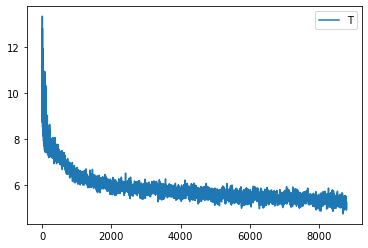

In [54]:
visualize_artifacts(artifacts)

In [55]:
test_loss = evaluate(best_model, test_data_batches, config)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  5.51 | test ppl   246.15


In [ ]:

# generate experiment configs
n_attention_heads_range = range(2,6)
n_layers_range = range(2,6)
experiment_datasets = [ Dataset.PennTreebank, Dataset.WikiText2, Dataset.WikiText103 ]
max_seq_len_range = range()
embedding_dimension
# datasets
def generateExperiements():
    # for each dataset
        # 
    config = {
        "embedding_dimension": 200,
        "ff_dimension": 200,
        "n_attention_heads": 2,
        "n_encoder_layers": 2,
        "n_decoder_layers": 2,
        "dataset": Dataset.PennTreebank,
        "max_seq_len": 35,
        "batch_size": 20,
        "eval_batch_size": 10,
        "n_epochs": 3
    }
    pass




    


In [ ]:
# pytorch lightnign experimentation
train_dataset, val_dataset, test_dataset, field_processor = load_data_pl(config)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"])
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"])



In [ ]:
# get scaling laws plots
    # map config values to scaling laws (model size, compute, dataset size)


In [ ]:
# visualize attention in encoder and decoder layers
# visualize